# Simulation 1: amplitudes, number of events and tolerance levels

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import  hmp
import bambi as bmb 
import pandas as pd
import arviz as az
import seaborn as sns
from os import listdir
import mne
from hmp import simulations
from scipy.stats import gamma
from itertools import product
from seaborn import color_palette

colors = iter([plt.cm.tab10(i) for i in range(10)])

def fit_or_load(filename, path, model):
    # if filename not in listdir(path):
    fit = model.fit(inference_method='nuts_numpyro')
    #     fit.to_netcdf(path+'/'+filename)
    # else:
    #     fit = az.from_netcdf(path+'/'+filename)
    return fit


## Illustrating recovery

In [9]:
# Run data creation script (Nothing happens if files already exist)
# !python run_simulations_SNR_section3-3.py

import os
import numpy as np
from scipy.stats import gamma as sp_dist
from hmp.utils import gamma_mean_to_scale
from joblib import Parallel, delayed
from hmp import simulations

# Just run same parameters as in the script to have them locally
seed = 1234

amplitudes = [.1e-7, .21e-7, .3e-7]

event_width = 50
n_trials = 1000#Number of trials to simulate
sfreq = 1000
n_comp = 5
distribution = 'gamma'
shape = 2

#Variable simulation parameters
n_events = [3,5]

cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
path = 'simulated/'#Where simulated data will go, create that folder if you don't have it where you're executing the code

#EEG specific
info = simulations.simulation_info()
all_other_chans = range(len(info.ch_names[:-61]))#non-eeg
chan_list = list(np.arange(len(info.ch_names)))
chan_list = [e for e in chan_list if e not in all_other_chans]
chan_list.pop(52)#Bad elec
info = mne.pick_info(info, sel=chan_list)
#Fixed simulation parameters
frequency = 10

Simulating ./simulated/1e-08_1trial_raw.fif
./simulated/1e-08_1trial_raw.fif simulated
Processing participant ./simulated/1e-08_1trial_raw.fif's continuous eeg
2 trials were retained for participant ./simulated/1e-08_1trial_raw.fif


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


Simulating ./simulated/2.1e-08_1trial_raw.fif
./simulated/2.1e-08_1trial_raw.fif simulated
Processing participant ./simulated/2.1e-08_1trial_raw.fif's continuous eeg
2 trials were retained for participant ./simulated/2.1e-08_1trial_raw.fif


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


Simulating ./simulated/3e-08_1trial_raw.fif
./simulated/3e-08_1trial_raw.fif simulated
Processing participant ./simulated/3e-08_1trial_raw.fif's continuous eeg
2 trials were retained for participant ./simulated/3e-08_1trial_raw.fif


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


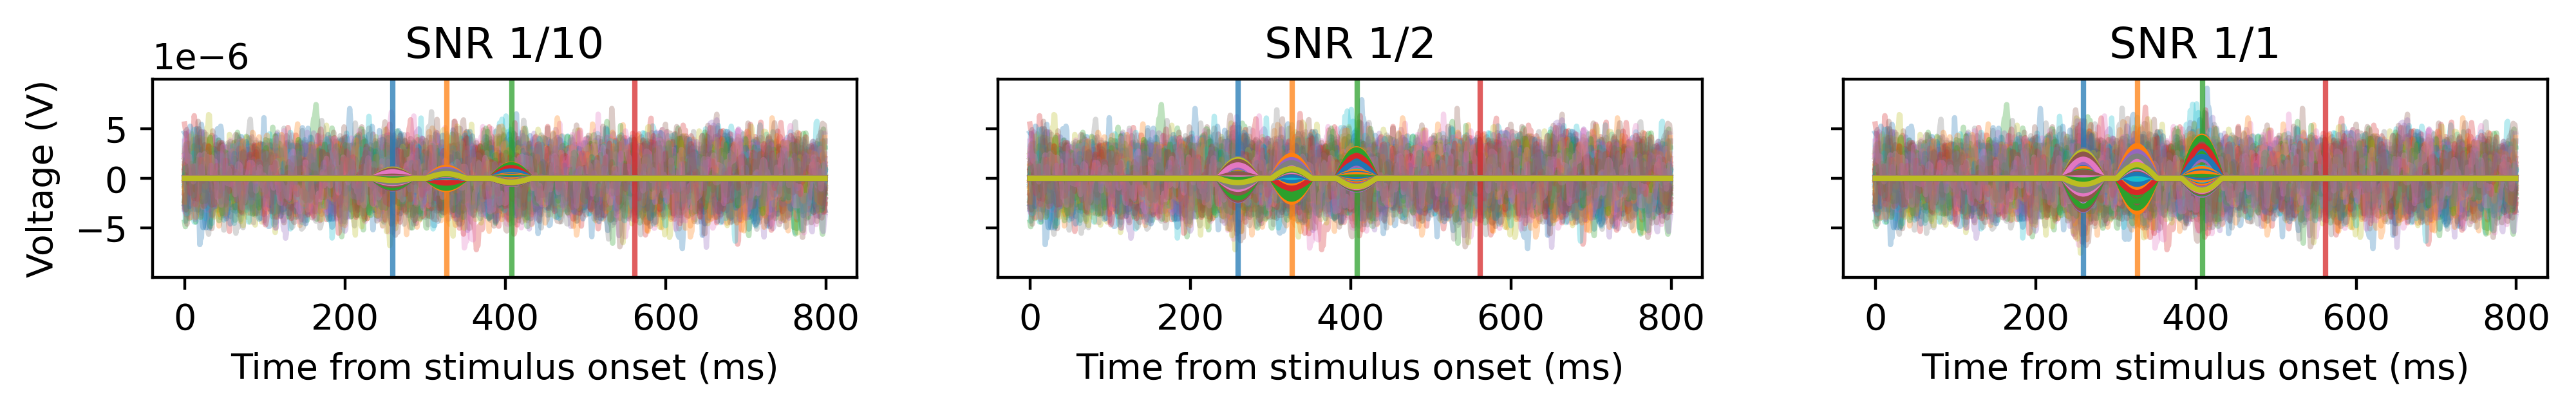

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,1), dpi=400, sharex=True, sharey=True)

Nevents = 4
means = np.array([100,100,100,100])/shape #Mean duration of the stages in ms
names =  simulations.available_sources()[:Nevents] #Which source to activate at each stage (see atlas when calling simulations.available_sources())
i = 0

amp_to_snr = {.1e-7:'1/10', .21e-7:'1/2', .3e-7:'1/1'}

for amplitude in amplitudes:

    sources = []
    for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
        sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

    file = simulations.simulate(sources, 2, 5, 'simulated/%s_1trial'%amplitude, 
                                sfreq=sfreq, overwrite=False, noise=True, save_snr=True, seed=3, save_noiseless=True)
    events = np.load(file[1])
    event_id = {'stimulus':1}#trigger 1 = stimulus
    # #Visualising the raw simulated EEG data
    raw_noiseless = mne.io.read_raw_fif(file[-1], preload=False, verbose=False)
    epochs_noiseless = mne.Epochs(raw_noiseless.load_data(), events = events, event_id=event_id, 
                        tmin = -0.25, tmax=3)
    epochs_noiseless.load_data()
    raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
    epochs = mne.Epochs(raw.load_data(), events = events, event_id=event_id, 
                        tmin = -0.25, tmax=3)
    epochs.load_data()
    
    ax[i].plot(epochs_noiseless.pick_types(eeg=True).get_data(copy=True).T[250:1050,:,0], zorder=10)
    ax[i].plot(epochs.pick_types(eeg=True).get_data(copy=True).T[250:1050,:,0], alpha=.3)
    ax[i].set_title(r'SNR %s'%amp_to_snr[amplitude])
    if i == 0:
        ax[i].set_ylabel('Voltage (V)')
        ax[i].set_yticks([-5e-6,0,5e-6])
    
    # Feeding data and initialize HMP
    #Recover info from simulation
    generating_events = np.load(file[1])
    resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
    event_id = {'stimulus':1}#trigger 1 = stimulus
    resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
    #Keeping only stimulus and response triggers
    events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

    epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                           sfreq=sfreq, events_provided=events, verbose=False)
    hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=5)
    init = hmp.models.hmp(hmp_data, sfreq=sfreq)#Initialization of the model
    random_source_times, _, _, _ = simulations.simulated_times_and_parameters(generating_events, init)
    random_source_times_cs = random_source_times.cumsum(axis=1)
    
    ev_colors = iter(color_palette(None, Nevents+1))
    for event in range(Nevents):
        ev_c = next(ev_colors)
        ax[i].vlines(random_source_times_cs[0,event], ymin=1e-5, ymax=-1e-5, color=ev_c, alpha=.75) 
    ax[i].set_ylim(-10e-6,10e-6)
    ax[i].set_xlabel('Time from stimulus onset (ms)')
    i += 1
    

plt.savefig('../../plots/ERPs_all-elec.png',dpi=300,transparent=True,bbox_inches='tight')

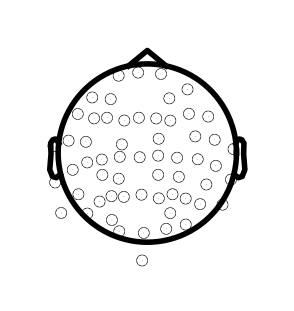

In [5]:
fig, ax = plt.subplots(1,1,figsize=(.75,.75), dpi=400)
mne.viz.plot_montage(raw.info.get_montage(), show=False, show_names=False, scale_factor=.01, axes=ax,)
raw_pick = raw.copy().pick(['EEG 034', 'EEG 001'])
# mne.viz.plot_montage(raw_pick.info.get_montage(), show=True, show_names=False, scale_factor=50, axes=ax)
fig.savefig('../../plots/montage.png',dpi=400,transparent=True,bbox_inches='tight')

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/3_1e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


0.11669449025530851
Processing participant simulated/3_1e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/3_1e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 3 events model
parameters estimated for 3 events model


  0%|          | 0/463 [00:00<?, ?it/s]

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/3_2.1e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


0.5089094298832284
Processing participant simulated/3_2.1e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/3_2.1e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 3 events model
parameters estimated for 3 events model


  0%|          | 0/463 [00:00<?, ?it/s]

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/3_3e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


1.023732661621555
Processing participant simulated/3_3e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/3_3e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 3 events model
parameters estimated for 3 events model


  0%|          | 0/463 [00:00<?, ?it/s]

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/5_1e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


0.11433266994303228
Processing participant simulated/5_1e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/5_1e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 5 events model
parameters estimated for 5 events model


  0%|          | 0/1036 [00:00<?, ?it/s]

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/5_2.1e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


0.5004462014010798
Processing participant simulated/5_2.1e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/5_2.1e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 5 events model
parameters estimated for 5 events model


  0%|          | 0/1036 [00:00<?, ?it/s]

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: simulated/5_3e-08_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


1.01125614141803
Processing participant simulated/5_3e-08_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant simulated/5_3e-08_raw.fif
We strongly advise to use a location > 0, if no correlation threshold is set.
Estimating 5 events model
parameters estimated for 5 events model


  0%|          | 0/1036 [00:00<?, ?it/s]

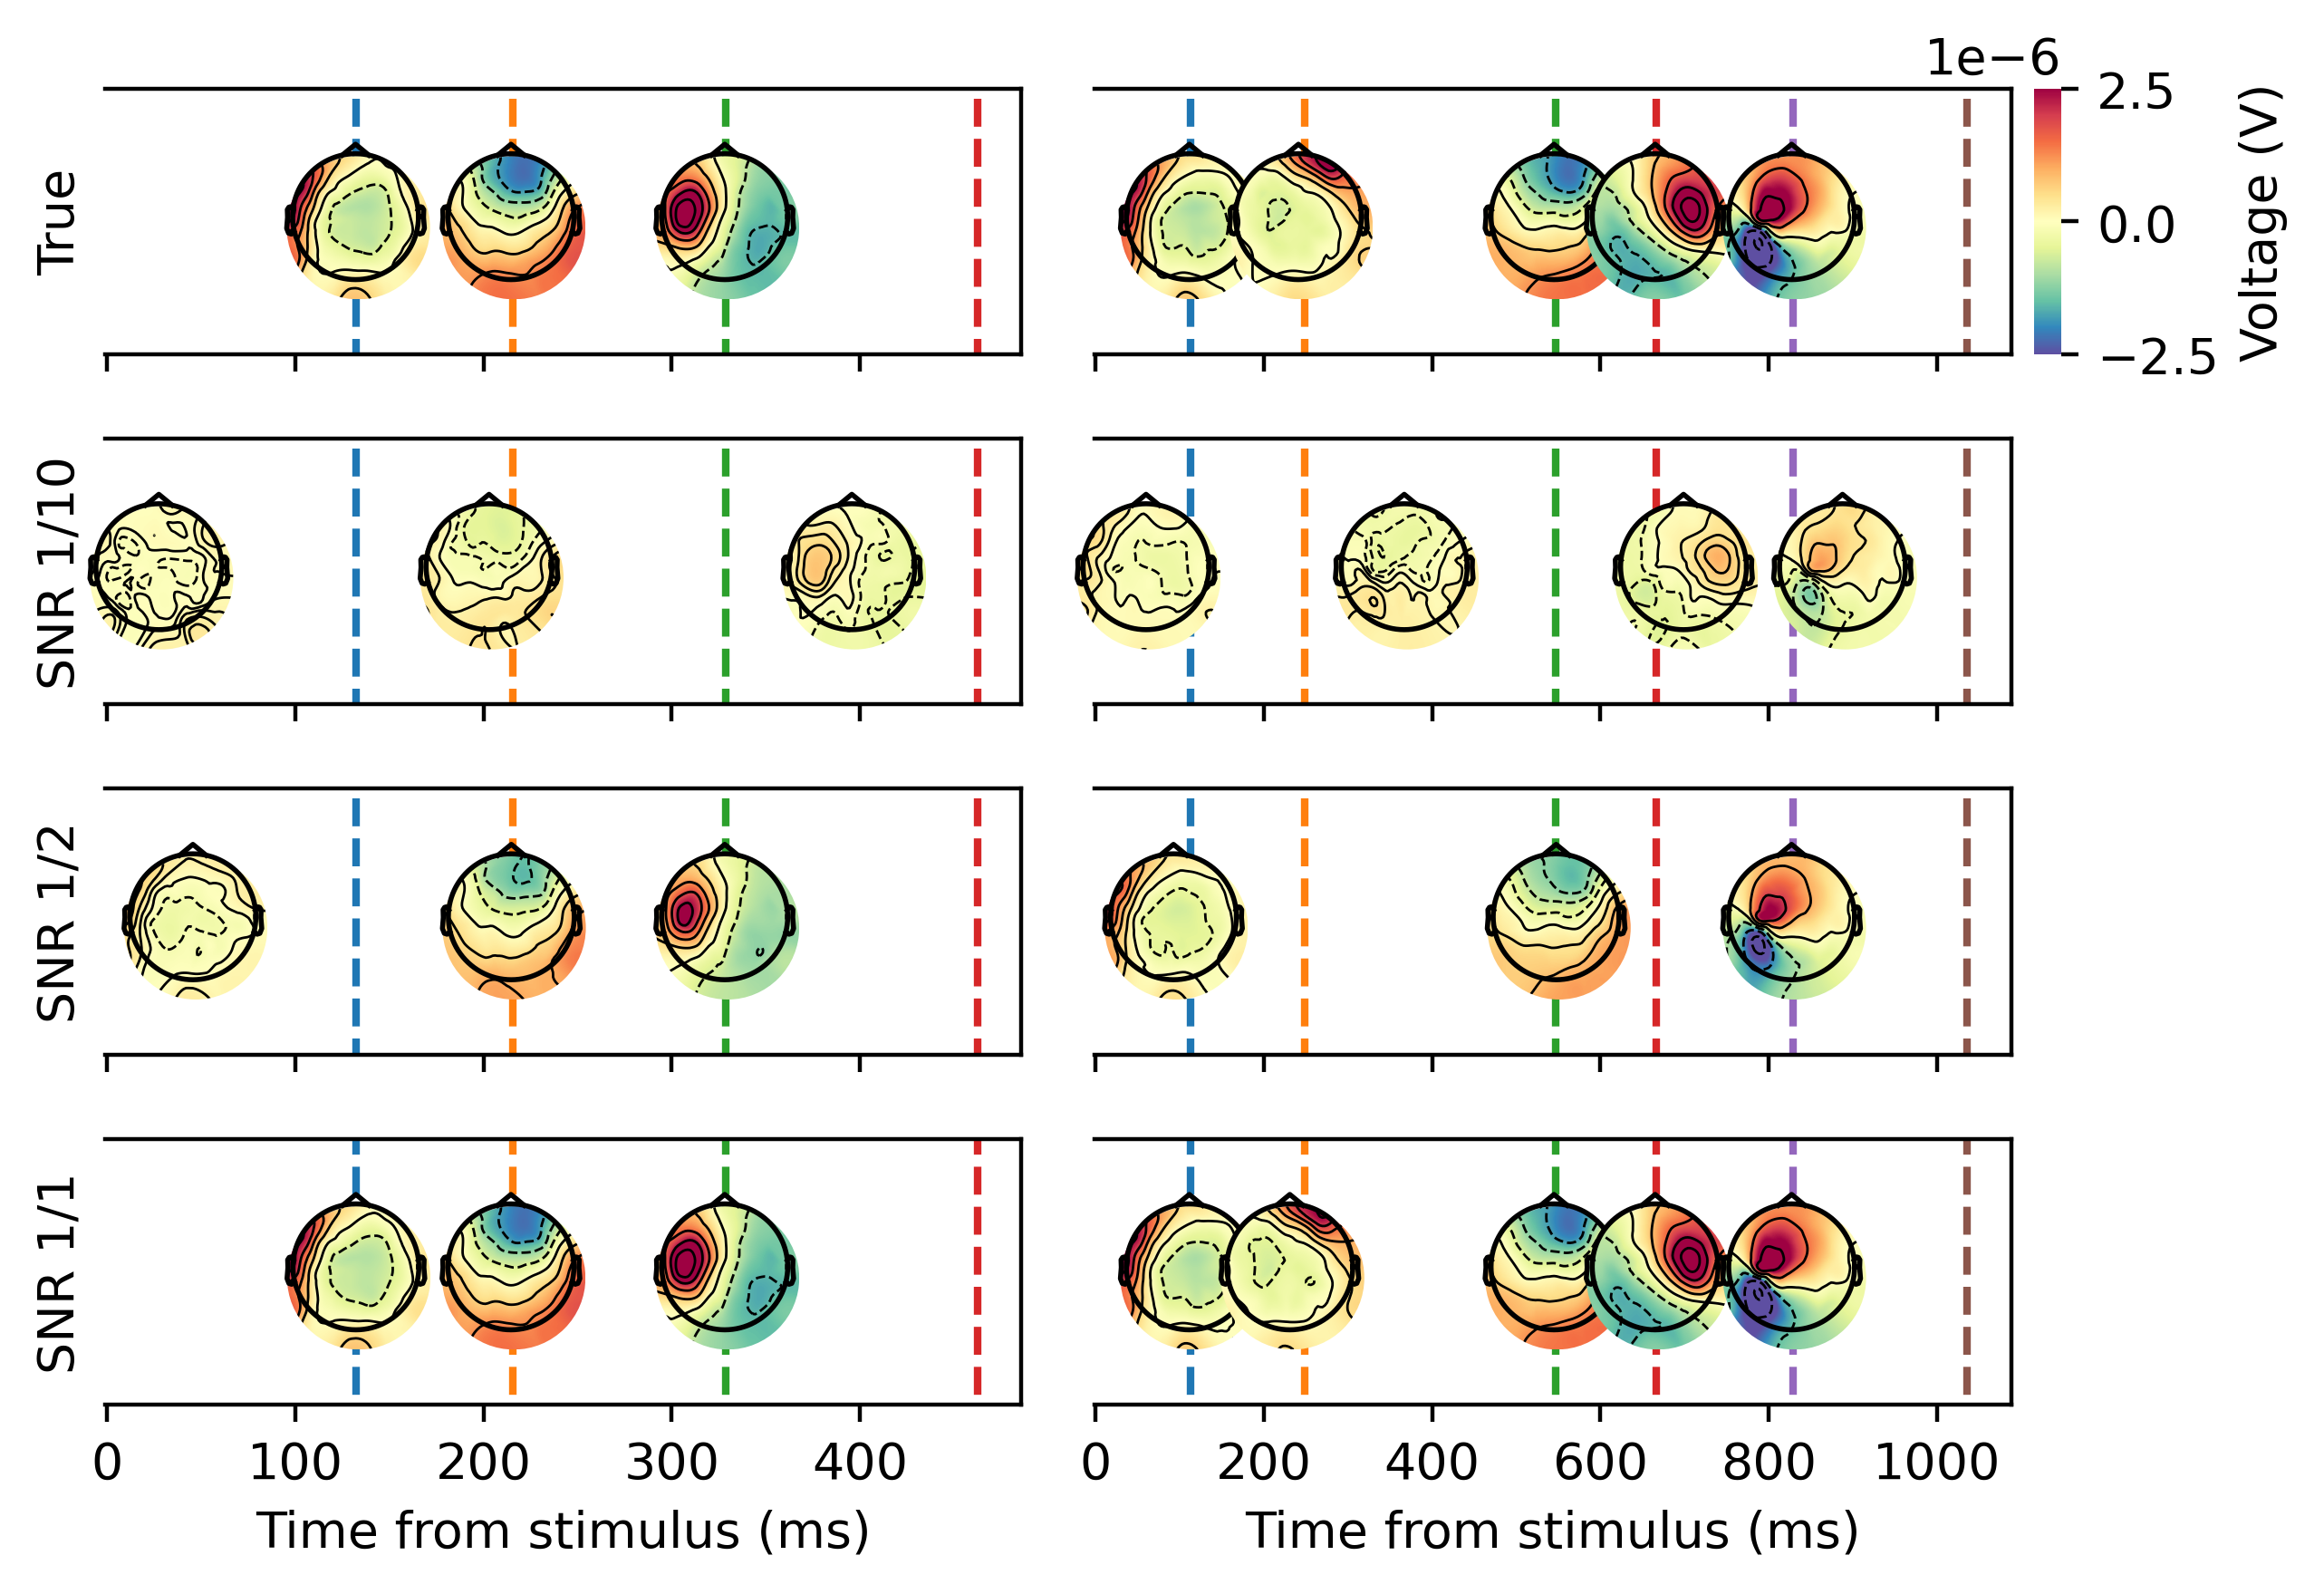

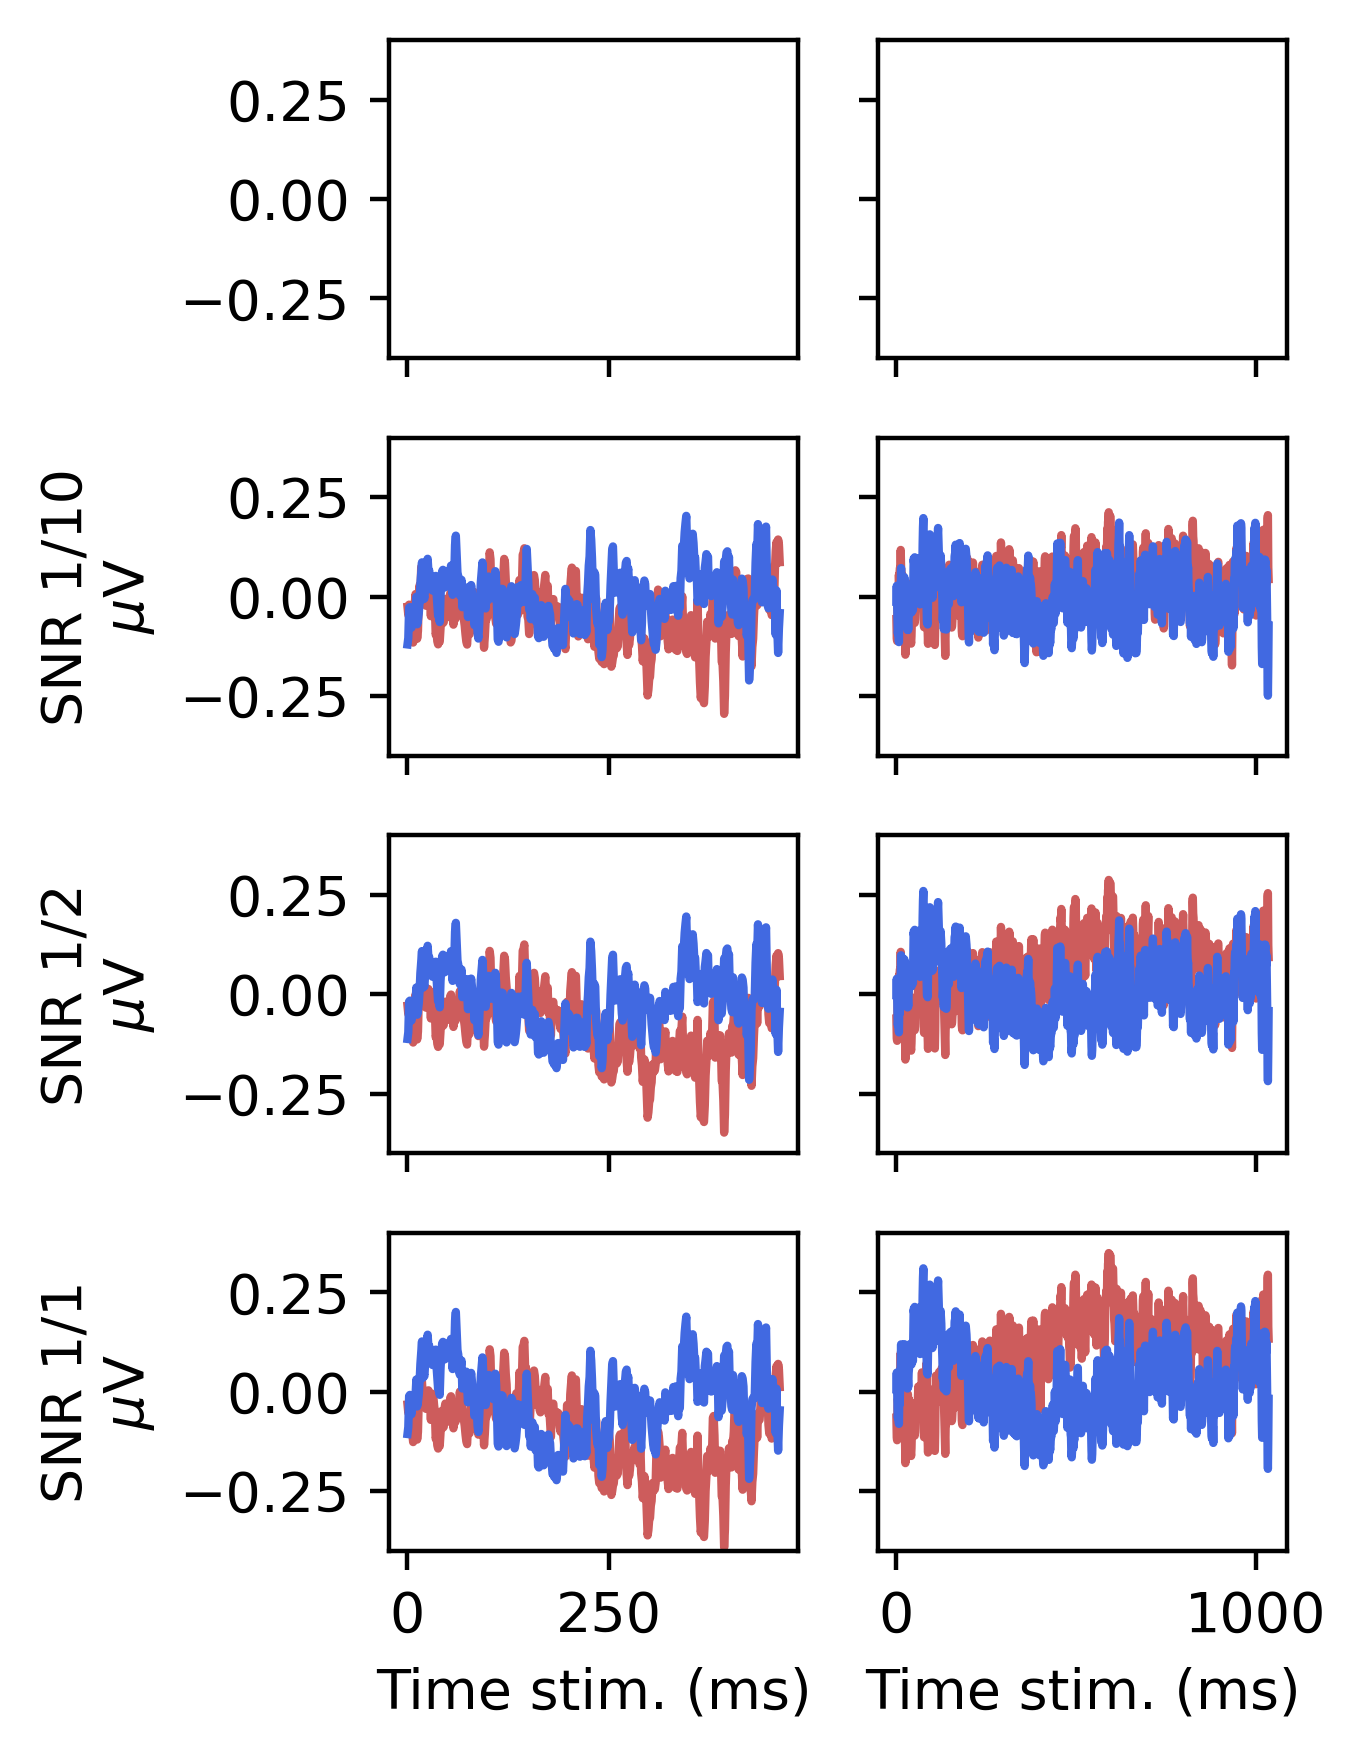

In [11]:
fig, ax = plt.subplots(4,2, figsize=(6.5,4.5), sharex='col', sharey='row', dpi=400)
fig2, ax2 = plt.subplots(4,2, figsize=(3.5,4.5), sharex='col', sharey=True, dpi=400)
map_nev_dict = {n_events[0]:0, n_events[1]:1}
map_amp_dict = {amplitudes[0]:1, amplitudes[1]:2, amplitudes[2]:3}

i = 0
for n_ev in n_events:
    color_dict = {i: color for i, color in enumerate(sns.color_palette(None, n_ev+1))}
    rng = np.random.default_rng(seed=seed)#Setting seed for reproducibility

    name_sources = rng.choice(simulations.available_sources(), n_ev+1, replace=False)
    means_list = rng.uniform(50,300,n_ev+1) 
    times = gamma_mean_to_scale(means_list, shape)
    for amplitude in amplitudes:
        sources = []
        for source in range(len(name_sources)):
            sources.append([name_sources[source], frequency, amplitude, \
                      sp_dist(shape, scale=times[source])])
        file = simulations.simulate(sources, n_trials, cpus, '%s_%s'%(n_ev,amplitude),
                                path=path, overwrite=False, sfreq=sfreq, seed=seed, save_snr=True)
        snr = np.load(file[2]).mean()
        print(snr)
        #Recover info from simulation
        generating_events = np.load(file[1])
        resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
        event_id = {'stimulus':1}#trigger 1 = stimulus
        resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
        #Keeping only stimulus and response triggers
        events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

        number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
        epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                    sfreq=sfreq, events_provided=events, verbose=False)
        
        hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)

        # Computing a true HMP model for the highest SNR
        true_init = hmp.models.hmp(hmp_data,epoch_data, sfreq=sfreq, event_width=event_width, cpus=cpus, distribution=distribution, shape=shape, location=0)#Initialization of the model
        #Recover the actualtime of the simulated events
        random_source_times, true_pars, true_amplitudes, true_activities = simulations.simulated_times_and_parameters(generating_events, true_init, data=hmp_data.data.T)
        mean_times = np.mean(np.cumsum(random_source_times,axis=1),axis=0)
        true_estimates = true_init.fit_single(number_of_sources-1, parameters = true_pars, magnitudes=true_amplitudes, maximization=False)
        if amplitude == amplitudes[-1]:
            if n_ev == 5:
                colorbar=True
            else: colorbar=False
            hmp.visu.plot_topo_timecourse(epoch_data, true_estimates, info, true_init, as_time=True, ax=ax[0, map_nev_dict[n_ev]], event_lines=None, times_to_display=np.mean(np.cumsum(random_source_times,axis=1),axis=0), vmin=-.25e-5, vmax=.25e-5,
                                           linecolors=list(color_dict.values()), colorbar = colorbar, magnify=2)
            ax[0, 0].set_ylabel('True')
        # Estimating an HMP model
        test_init = hmp.models.hmp(hmp_data, epoch_data, sfreq=sfreq, event_width=event_width, cpus=cpus, distribution=distribution, shape=shape, location=25)#Initialization of the model
        test_estimates = test_init.fit(verbose=False)
        hmp.visu.plot_topo_timecourse(epoch_data, test_estimates, info, test_init, as_time=True,  ylabels=[np.round(snr)], ax=ax[map_amp_dict[amplitude], map_nev_dict[n_ev]], event_lines=None, vmin=-.25e-5, vmax=.25e-5,
                                      times_to_display=mean_times, linecolors=list(color_dict.values()), colorbar=False, magnify=2)
        i += 1
        # Plotting ERP
        data = epoch_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
        times_erp = true_init.compute_times(true_init, true_estimates, fill_value=0, add_rt=True)
        centered = hmp.utils.centered_activity(data, times_erp, ["EEG 034"], event=0, n_samples=mean_times[-1], baseline=0)
        ax2[map_amp_dict[amplitude], map_nev_dict[n_ev]].plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data*1e6, color='indianred')
        centered = hmp.utils.centered_activity(data, times_erp, ["EEG 001"], event=0, n_samples=mean_times[-1], baseline=0)
        ax2[map_amp_dict[amplitude], map_nev_dict[n_ev]].plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data*1e6, color='royalblue')
        ax[-1, map_nev_dict[n_ev]].set_xlabel('Time from stimulus (ms)')
        ax2[-1, map_nev_dict[n_ev]].set_xlabel('Time stim. (ms)')
        ax[map_amp_dict[amplitude], 0].set_ylabel(f'SNR {amp_to_snr[amplitude]}')
        ax2[map_amp_dict[amplitude], 0].set_ylabel(f'SNR {amp_to_snr[amplitude]}\n' r'$\mu$V')

ax2[-1, map_nev_dict[n_ev]].set_ylim(-.4,.4)
fig.tight_layout()
fig2.tight_layout()
fig.savefig('../../SNR_topo.png', dpi=300,transparent=True,bbox_inches='tight',backend='cairo')
fig2.savefig('../../SNR_ERPs.png', dpi=300,transparent=True,bbox_inches='tight',backend='cairo')